In this notebook, we simulate the various corrosion-driven mechanisms within a fracatal porous media. 

#### Affiliations & E-mails
- Mohit Pundir: mpundir@ethz.ch

¹: Computational Mechanics of Building Materials, ETH Zurich, Switzerland.

The code given here is provided for reproducibility purposes, but you are free to reuse the code under the terms of the MIT License. The presented FFT-based code is an extension of the code provided in T.W.J. de Geus, J. Vondřejc, J. Zeman, R.H.J. Peerlings, M.G.D. Geers. Finite strain FFT-based non-linear solvers made simple. Submitted, 2016. arXiv: 1603.08893

### License
Copyright (c) 2023 CMBM, ETH Zurich

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Environment setup
We start by setting up the data and python packages we need. 

In [1]:
from plot_helper_for_paper import *
import numpy as np
import scipy.sparse.linalg as sp
import itertools
from IPython.display import clear_output

In [2]:
def put_label(ax, label, x=0.05, fontsize=10):
    ax.text(x, 0.975, label, transform=ax.transAxes,
      fontsize=fontsize, fontweight='bold', va='top')

> The length of the considered __Representative Volume Element__ is _1 mm_

In [3]:
length = 1 # mm length of the microstructure

## FIB/SEM scan

We read the 2D FIB/SEM scan of a cementitious material. The pores are represented as white and solid as grey. 

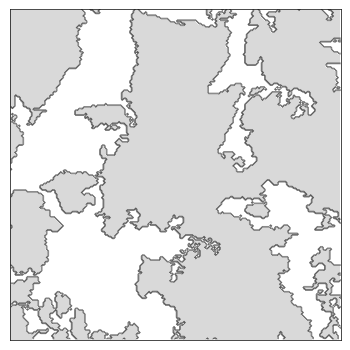

In [4]:
structure = np.loadtxt('../inputs/fractal.txt')
delta_space = length/structure.shape[0]

plt.figure(figsize=set_size(fraction=1), dpi=100)
ax = plt.axes()
ax.contourf(np.ma.array(1-structure[:, :].T, mask=structure.T), alpha=1,  cmap='Greys')
ax.contour(structure.T,
                  origin='lower', colors=['xkcd:black'], linewidths=0.1)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_aspect(1/ax.get_data_ratio())

plt.show()

In [5]:
structure = structure.T

## Diffusion Calculations

In [6]:
def compute_Ghat_2_1(structure, length=1, operator='forward-difference'):
    ndim = len(structure.shape)
    N     = ndim*(structure.shape[0],)    # number of voxels (assumed equal for all directions)
    
    # PROJECTION IN FOURIER SPACE #############################################
    Ghat2_1 = np.zeros((ndim,ndim)+ N, dtype='complex') # zero initialize
    freq = [np.arange(-(N[ii]-1)/2.,+(N[ii]+1)/2.) for ii in range(ndim)]
    for i,j in itertools.product(range(ndim),repeat=2):
        for ind in itertools.product(*[range(n) for n in N]):
            q = np.empty(ndim, dtype='complex')
            Dop = np.empty(ndim, dtype='complex')
            for ii in range(ndim):
                q[ii] = 2*np.pi*freq[ii][ind[ii]] ## frequency vector
                if operator == 'fourier':
                    Dop[ii] = 1j*q[ii]                                   
                elif operator == 'central-difference':
                    Dop[ii] = 1j*np.sin(q[ii]*delta_space)/delta_space   
                elif operator == '4-order-cd':
                    Dop[ii] = -1j*(8*np.sin(q[ii]*delta_space)/(6*delta_space) - np.sin(2*q[ii]*delta_space)/(6*delta_space))   
                elif operator == '8-order-cd':
                    Dop[ii] = -1j*(8*np.sin(q[ii]*delta_space)/(5*delta_space) - 2*np.sin(2*q[ii]*delta_space)/(5*delta_space) + 8*np.sin(3*q[ii]*delta_space)/(105*delta_space) - np.sin(4*q[ii]*delta_space)/(140*delta_space) ) 
                elif operator == 'forward-difference':
                    Dop[ii] = (np.exp(1j*q[ii]*delta_space)-1)/delta_space
                else:
                    raise RuntimeError('operator incorrectly defined')
        
            if not Dop.dot(np.conjugate(Dop)) == 0:          # zero freq. -> mean
                Dop_inverse = np.conjugate(Dop)/(Dop.dot(np.conjugate(Dop)))
                Ghat2_1[i,j][ind] = Dop[i]*Dop_inverse[j]      

    return Ghat2_1

In [7]:
def perform_diffusion(structure, A, macro_gradient, Ghat, solver=sp.lgmres):
    ndim  = 2                             # number of dimensions (works for 2D and 3D)
    N     = ndim*(structure.shape[0],)    # number of voxels (assumed equal for all directions)

    # auxiliary values
    prodN = np.prod(np.array(N)) # number of grid points
    ndof  = ndim*prodN # number of degrees-of-freedom
    vec_shape=(ndim,)+N # shape of the vector for storing DOFs

    
    E = np.zeros(vec_shape); 
    E[0] = macro_gradient[0] # set macroscopic loading
    E[1] = macro_gradient[1] # set macroscopic loading
     
    # OPERATORS ###############################################################
    dot21  = lambda A,v: np.einsum('ij...,j...  ->i...',A,v)
    fft    = lambda V: np.fft.fftshift(np.fft.fftn (np.fft.ifftshift(V),N))
    ifft   = lambda V: np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(V),N))
    G_fun  = lambda V: np.real(ifft(dot21(Ghat,fft(V)))).reshape(-1)
    A_fun  = lambda v: -dot21(A,v.reshape(vec_shape))
    DA_fun = lambda v: G_fun(A_fun(v))

    # NEWTON-CONJUGATE GRADIENT SOLVER ###############################################
    aux      =            E.copy()
    En       = np.linalg.norm(aux)
    iiter    = 0

    bd       = -DA_fun(E) # initial residual
    
    nb_iterations = 0
    def callback(x):
        nonlocal nb_iterations
        nb_iterations += 1
    
    while True:
        e, _=  solver(
                    A=sp.LinearOperator(shape=(ndof, ndof), matvec=DA_fun, dtype='float'), 
                    b=bd, callback=callback,
                    tol=1e-8, atol=1e-8)
        aux += e.reshape(vec_shape)
        bd   = -DA_fun(aux) 
    
        if np.abs(np.linalg.norm(e))/En<1e-10 and iiter>0:
            print('Diffusion Calculation converged :', nb_iterations)
            break # check convergence
        iiter += 1

    aux = aux.reshape(-1)
        
    return aux.reshape(vec_shape), A_fun(aux).reshape(vec_shape), nb_iterations

## Optimal value of $D$ for solid 

In [8]:
diffusion_coefficients_solids = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-8]
free_diffusion_coefficient = 1.

num_iters = []
d_eff_x = []
d_eff_y = []
fluxes = []


# PROBLEM DEFINITION ######################################################
ndim = 2

macro_gradient = [1e-6, 1e-6]

Ghat2_1 = compute_Ghat_2_1(structure, operator='forward-difference')
for d_solid in diffusion_coefficients_solids:
    A = np.einsum('ij,...->ij...',np.eye(ndim), 
                      structure*free_diffusion_coefficient + (1-structure)*d_solid) # material coefficients
       
    aux, flux, nb_iterations = perform_diffusion(structure=structure, 
                                                macro_gradient=macro_gradient, 
                                                A=A, 
                                                Ghat=Ghat2_1, solver=sp.bicgstab)
    
    avg_properties = np.zeros(len(structure.shape))
    avg_flux = np.zeros(len(structure.shape))
    avg_flux_pores = np.zeros(len(structure.shape))
    avg_flux_solid = np.zeros(len(structure.shape))

    for i in range(len(structure.shape)):
        avg_properties[i] = np.mean(-flux[i, :, :])/macro_gradient[i]
        avg_flux[i] = -avg_properties[i]*macro_gradient[i]
        avg_flux_pores[i] = np.mean(np.ma.array(flux[i, :, :], mask=1-structure))

        avg_flux_solid[i] = np.mean(np.ma.array(flux[i, :, :], mask=structure))
        
    d_eff_x.append( avg_properties[0] )
    d_eff_y.append( avg_properties[1] )
    fluxes.append([np.mean(flux[0, :, :]), np.mean(flux[0, :, :]) ])
    num_iters.append( nb_iterations )

Diffusion Calculation converged : 2
Diffusion Calculation converged : 10
Diffusion Calculation converged : 27
Diffusion Calculation converged : 41
Diffusion Calculation converged : 43
Diffusion Calculation converged : 42
Diffusion Calculation converged : 43
Diffusion Calculation converged : 42


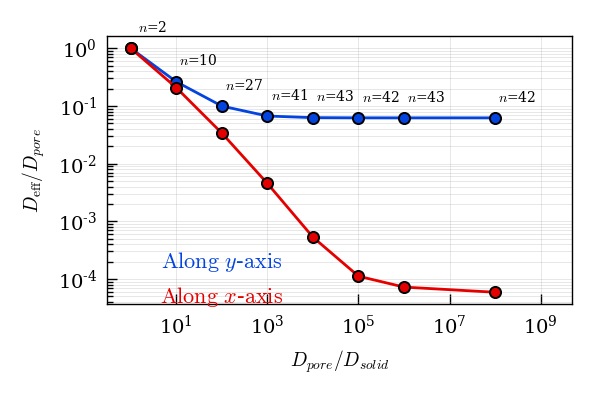

In [11]:
fig = plt.figure(figsize=set_size(fraction=0.4, height_ratio=0.65), dpi=200, constrained_layout=True)
axe = plt.axes()
axe.loglog(1/np.asarray(diffusion_coefficients_solids), d_eff_x, color='xkcd:blue', lw=1, marker='o', markeredgecolor='k', markeredgewidth=0.7, markersize=4)
axe.loglog(1/np.asarray(diffusion_coefficients_solids), d_eff_y, color='xkcd:red', lw=1,  marker='o', markeredgecolor='k', markeredgewidth=0.7, markersize=4)


for i in range(len(np.asarray(diffusion_coefficients_solids))):
    label = r'$n$='+str(num_iters[i])
    plt.annotate(label, # this is the text
                 (1/np.asarray(diffusion_coefficients_solids)[i], d_eff_x[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(8,6), # distance from text to points (x,y)
                 ha='center', fontsize=5) # horizontal alignment can be left, right or center

#axe.set_ylim(top=10, bottom=1e-5)

axe.set_xlim(left=0.3, right=5e9)

axe.text(100, 2e-4, r'$\mathrm{Along}~y$-$\mathrm{axis}$', color='xkcd:blue', horizontalalignment='center',
     verticalalignment='center', fontsize=8)
axe.text(100, 5e-5, r'$\mathrm{Along}~x$-$\mathrm{axis}$', color='xkcd:red', horizontalalignment='center',
     verticalalignment='center', fontsize=8)


plt.xlabel(r'$D_{pore}/D_{solid}$')
plt.ylabel(r'$D_\mathrm{eff}/D_{pore}$')
plt.grid(visible=True, which='both', alpha=0.35, lw=0.3)
plt.show()

## Diffusion Calculations

In [12]:
diffusion_coefficients = {}
diffusion_coefficients['pore'] = 1. # mm2/s
diffusion_coefficients['solid'] = 1e-6

# PROBLEM DEFINITION ######################################################
ndim = 2
A = np.einsum('ij,...->ij...',np.eye(ndim), 
                  structure*diffusion_coefficients['pore'] + (1-structure)*diffusion_coefficients['solid']) # material coefficients

macro_gradient = [1e-5, 1e-5]
Ghat2_1 = compute_Ghat_2_1(structure, operator='forward-difference')
aux, flux, nb_iterations = perform_diffusion(structure=structure, 
                                            macro_gradient=macro_gradient, 
                                            A=A, 
                                            Ghat=Ghat2_1, solver=sp.bicgstab)

Diffusion Calculation converged : 50


In [13]:
avg_properties = np.zeros(len(structure.shape))
avg_flux = np.zeros(len(structure.shape))
avg_flux_pores = np.zeros(len(structure.shape))
avg_flux_solid = np.zeros(len(structure.shape))

for i in range(len(structure.shape)):
    avg_properties[i] = np.mean(-flux[i, :, :])/macro_gradient[i]
    avg_flux[i] = -avg_properties[i]*macro_gradient[i]
    avg_flux_pores[i] = np.mean(np.ma.array(flux[i, :, :], mask=1-structure))

    avg_flux_solid[i] = np.mean(np.ma.array(flux[i, :, :], mask=structure))

    
print('Effective properties :', avg_properties)
print('Effective Flux       :', avg_flux)
print('Macro Gradient       :', macro_gradient)
print('Mean Flux Pores      :', avg_flux_pores)
print('Mean Flux Solid      :', avg_flux_solid)

Effective properties : [6.23120096e-02 1.23062551e-05]
Effective Flux       : [-6.23120096e-07 -1.23062551e-10]
Macro Gradient       : [1e-05, 1e-05]
Mean Flux Pores      : [-1.69465061e-06 -3.07492244e-10]
Mean Flux Solid      : [-1.48296403e-11 -1.58149170e-11]


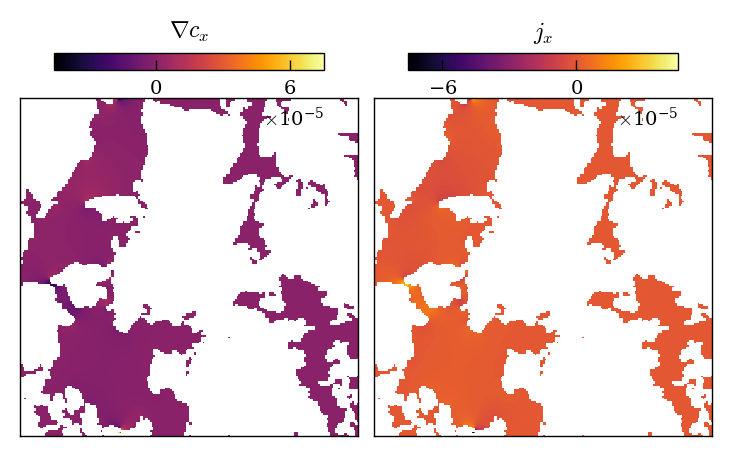

In [14]:
fig = plt.figure(figsize=set_size(fraction=0.5, height_ratio=1), dpi=200, constrained_layout=True)
gs1 = fig.add_gridspec(1, 2, wspace=0.001, hspace=0.001)

ax = fig.add_subplot(gs1[0, 0])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(aux[1, :, :], mask=1-structure[:, :]), 
            title=r'$\nabla c_{x}$')

ax = fig.add_subplot(gs1[0, 1])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(flux[1, :, :], mask=1-structure[:, :]),
            title=r'$j_{x}$')


plt.show()

### Concentration

In [15]:
def compute_periodic_fluctuations(structure, concentration_gradients, ndim=2):
    N = structure.shape[0]
    shape  = structure.shape

    # (inverse) Fourier transform (for each tensor component in each direction)
    fft  = lambda x: np.fft.fftshift(np.fft.fftn (np.fft.ifftshift(x),[N,N]))
    ifft = lambda x: np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x),[N,N]))
    dot11  = lambda A1,B1: np.einsum('ixy   ,ixy   ->xy    ',A1,B1)


    x_2     = np.zeros([ndim   ,N,N],dtype='int64')  # position vectors
    q_2     = np.zeros([ndim   ,N,N],dtype='float')  # frequency vectors

    # - set "x_2" as position vector of all grid-points
    x_2[0],x_2[1] = np.mgrid[:N,:N]

    # - convert positions "x_2" for frequencies "q_2"
    for i in range(ndim):
        freq   = np.arange(-(shape[i]-1)/2,+(shape[i]+1)/2,dtype='int64')
        q_2[i] = 2*np.pi*freq[x_2[i]]

    tau     = concentration_gradients.reshape([ndim, N, N]).copy()
    R       = 1j*(np.multiply(q_2[0], fft(tau[0, :, :])) + np.multiply(q_2[1],fft(tau[1, :, :])))
    q_2     = q_2.astype(float)
    Q       = dot11(q_2,q_2)
    Z       = Q==0
    Q[Z]    = 1.
    norm    = 1./Q
    norm[Z] = 0.
    R  *= norm
    phi = np.real(ifft(-R))
    
    return phi

In [16]:
def compute_micro_concentration(structure, A, concentration_gradients, macro_concentration=1, length=1, ndim=2):
    phi = compute_periodic_fluctuations(structure=structure, concentration_gradients=concentration_gradients)
    
    N  = ndim*(structure.shape[0],)    # number of voxels (assumed equal for all directions)

    vec_shape=(ndim,)+N # shape of the vector for storing DOFs
    

    dot11  = lambda A1,B1: np.einsum('ixy   ,ixy   ->xy    ',A1,B1)
    dot21  = lambda A,v: np.einsum('ij...,j...  ->i...',A,v)
    A_fun  = lambda v: -dot21(A,v.reshape(vec_shape))
    
    x = np.linspace(0, length, num=structure.shape[0])
    xx = np.zeros(vec_shape)
    xx[0], xx[1] = np.meshgrid(x, x)
    E_x = dot11(concentration_gradients, xx) 

    avg_flux = np.zeros(len(structure.shape))
    avg_flux_pores = np.zeros(len(structure.shape))
    avg_flux_solid = np.zeros(len(structure.shape))

    for i in range(len(structure.shape)):
        avg_flux[i] = -np.mean(-A_fun(concentration_gradients.reshape(-1)).reshape(vec_shape)[i, :, :])
        avg_flux_pores[i] = np.mean(np.ma.array(A_fun(concentration_gradients.reshape(-1)).reshape(vec_shape)[i, :, :], mask=1-structure))
        avg_flux_solid[i] = np.mean(np.ma.array(A_fun(concentration_gradients.reshape(-1)).reshape(vec_shape)[i, :, :], mask=structure))

    xsi = np.zeros_like(E_x)
    xsi[structure==1] = np.linalg.norm(avg_flux_pores)*macro_concentration/np.linalg.norm(avg_flux) - np.mean(np.ma.array(E_x, mask=1-structure))
    xsi[structure==0] = np.linalg.norm(avg_flux_solid)*macro_concentration/np.linalg.norm(avg_flux) - np.mean(np.ma.array(E_x, mask=structure))

    concentration =  E_x + phi + xsi
    return concentration, phi

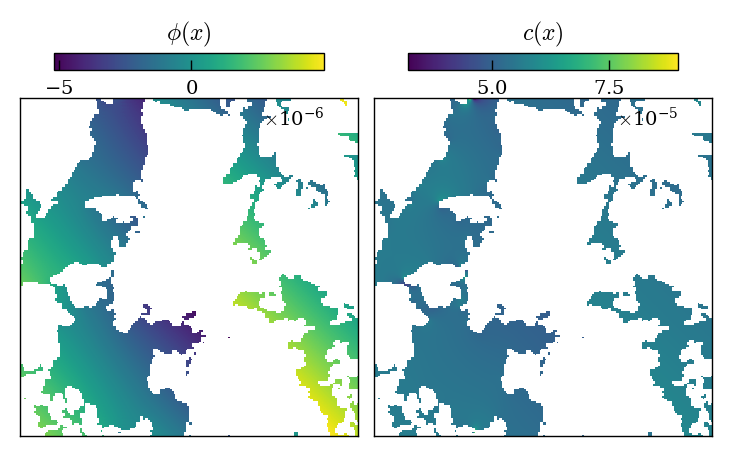

In [17]:
concentration, phi = compute_micro_concentration(structure=structure,
                                                 A=A,
                                                 concentration_gradients=aux, 
                                                 macro_concentration=2e-5)

fig = plt.figure(figsize=set_size(fraction=0.5, height_ratio=1), dpi=200, constrained_layout=True)
gs1 = fig.add_gridspec(1, 2, wspace=0.001, hspace=0.001)

ax = fig.add_subplot(gs1[0, 0])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(phi, mask=1-structure[:, :]),
            title=r'$\phi(x)$', cmap='viridis')

ax = fig.add_subplot(gs1[0, 1])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(concentration, mask=1-structure[:, :]),
            title=r'$c(x)$', cmap='viridis')


plt.show()

## Chemical reactions in Pores

> At a constant pH of 8

In [18]:
def compute_eigen_strain(structure, concentration, delta_space, density=3.4e-3, 
                         threshold_concentration=1e-3/1e6, ndim=2, molar_mass=89):
    # computing precipiate concentration
    precipitation = np.where(concentration > threshold_concentration, concentration-threshold_concentration, 0)
    
    cell_volume = delta_space**ndim
    moles_precipitation = precipitation*cell_volume
    volume_precipitation = moles_precipitation*molar_mass/density

    eigen_strain = (volume_precipitation-cell_volume)/(cell_volume)
    eigen_strain = np.where(eigen_strain > 0, eigen_strain, 0)*structure
    
    precipitate_fraction = np.abs(volume_precipitation)/(cell_volume)
    precipitate_fraction = np.where(precipitate_fraction > 0.9, 0.9, precipitate_fraction)
    precipitate_fraction = np.where(structure == 0, 0, precipitate_fraction)
    porosity_reduction = np.where(precipitate_fraction > 0, 1-precipitate_fraction, 1 )
    porosity_reduction = np.where(structure == 0, 1, porosity_reduction)

    return eigen_strain, precipitation, porosity_reduction

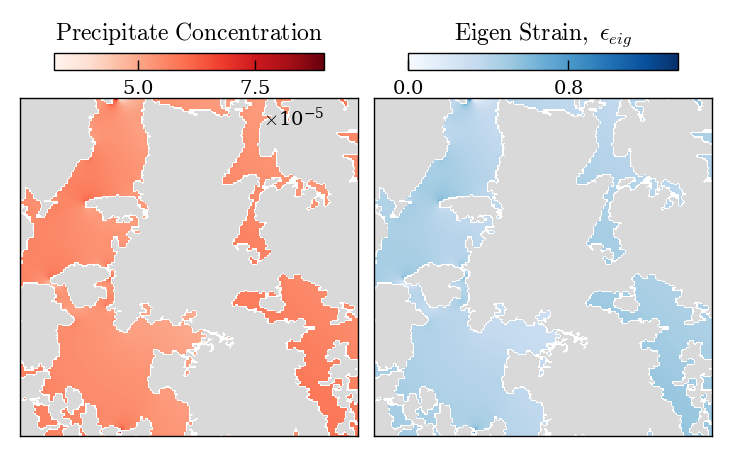

In [19]:
eigen_strain, precipitation, porosity_reduction = compute_eigen_strain(structure=structure, concentration=concentration, 
                                                                       delta_space=delta_space)

fig = plt.figure(figsize=set_size(fraction=0.5, height_ratio=1), dpi=200, constrained_layout=True)
gs1 = fig.add_gridspec(1, 2, wspace=0.001, hspace=0.001)

ax = fig.add_subplot(gs1[0, 0])
ax.contourf(np.ma.array(1-structure[:, :], mask=structure), alpha=1,  cmap='Greys')
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(precipitation, mask=1-structure),
            title=r'$\mathrm{Precipitate~Concentration}$', cmap='Reds')

ax = fig.add_subplot(gs1[0, 1])
ax.contourf(np.ma.array(1-structure[:, :], mask=structure), alpha=1,  cmap='Greys')
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(eigen_strain, mask=1-structure),
            title=r'$\mathrm{Eigen~Strain},~\epsilon_{eig}$', cmap='Blues')

## Computing stress due to pressurization

In [20]:
def compute_Ghat_4_2(structure, length=1, operator='forward-difference'):
    ndim   = len(structure.shape)
    NN     = ndim*(structure.shape[0],)    # number of voxels (assumed equal for all directions)
    
    Ghat4_2 = np.zeros((ndim,ndim, ndim, ndim)+ NN, dtype='complex') # zero initialize
    freq = [np.arange(-(NN[ii]-1)/2.,+(NN[ii]+1)/2.) for ii in range(ndim)]
    delta   = lambda i,j: float(i==j)               # Dirac delta function

    for i,j,l,m in itertools.product(range(ndim),repeat=4):
        for ind in itertools.product(*[range(n) for n in NN]):
            q = np.empty(ndim, dtype='complex')
            Dop = np.empty(ndim, dtype='complex')
            for ii in range(ndim):
                q[ii] = 2*np.pi*freq[ii][ind[ii]]   ## frequency vector
                if operator == 'fourier':
                    Dop[ii] = 1j*q[ii]                  ## [fourier operator]
                elif operator == 'forward-difference':
                    Dop[ii] = (np.exp(1j*q[ii]*delta_space)-1)/delta_space             
                elif operator == 'central-difference':
                    Dop[ii] = 1j*np.sin(q[ii]*delta_space)/delta_space    
                elif operator == '4-order-cd':
                    Dop[ii] = -1j*(8*np.sin(q[ii]*delta_space)/(6*delta_space) - np.sin(2*q[ii]*delta_space)/(6*delta_space))    ## [fourth-order central difference operator]
                elif operator == '8-order-cd':
                    Dop[ii] = -1j*(8*np.sin(q[ii]*delta_space)/(5*delta_space) - 2*np.sin(2*q[ii]*delta_space)/(5*delta_space) + 8*np.sin(3*q[ii]*delta_space)/(105*delta_space) - np.sin(4*q[ii]*delta_space)/(140*delta_space) ) 
              
            
            if not Dop.dot(np.conjugate(Dop)) == 0:          # zero freq. -> mean
                Dop_inverse = np.conjugate(Dop)/(Dop.dot(np.conjugate(Dop)))
                Ghat4_2[i,j,l,m][ind] = delta(i,m)*Dop[j]*Dop_inverse[l]

    return Ghat4_2

In [21]:
def compute_stress(structure, K, mu, eigen_strain, Ghat4_2, macro_strain=[0, 0]):
    N = structure.shape[0]
    ndof   = ndim**2*N**2 # number of degrees-of-freedom
    shape  = [N,N]         # number of voxels in all directions
    
    # tensor operations/products: np.einsum enables index notation, avoiding loops
    # e.g. ddot42 performs $C_ij = A_ijkl B_lk$ for the entire grid
    trans2 = lambda A2   : np.einsum('ijxy         ->jixy  ',A2   )
    trace2 = lambda A2   : np.einsum('iixy         ->xy    ',A2   )
    ddot22 = lambda A2,B2: np.einsum('ijxy  ,jixy  ->xy    ',A2,B2)
    ddot42 = lambda A4,B2: np.einsum('ijklxy,lkxy  ->ijxy  ',A4,B2)
    ddot44 = lambda A4,B4: np.einsum('ijklxy,lkmnxy->ijmnxy',A4,B4)
    dot11  = lambda A1,B1: np.einsum('ixy   ,ixy   ->xy    ',A1,B1)
    dot22  = lambda A2,B2: np.einsum('ijxy  ,jkxy  ->ikxy  ',A2,B2)
    dot24  = lambda A2,B4: np.einsum('ijxy  ,jkmnxy->ikmnxy',A2,B4)
    dot42  = lambda A4,B2: np.einsum('ijklxy,lmxy  ->ijkmxy',A4,B2)
    dyad22 = lambda A2,B2: np.einsum('ijxy  ,klxy  ->ijklxy',A2,B2)

    # identity tensor (single tensor)
    i    = np.eye(3)
    # identity tensors (grid)
    I2    = np.einsum('ij,xy'          ,                  np.eye(2)   ,np.ones([N,N]))
    I    = np.einsum('ij,xy'          ,                  i   ,np.ones([N,N]))
    I4   = np.einsum('ijkl,xy->ijklxy',np.einsum('il,jk',i,i),np.ones([N,N]))
    I4rt = np.einsum('ijkl,xy->ijklxy',np.einsum('ik,jl',i,i),np.ones([N,N]))
    I4s  = (I4+I4rt)/2.
    II   = dyad22(I,I)
    I4d    = (I4s-II/3.)

    # (inverse) Fourier transform (for each tensor component in each direction)
    fft  = lambda x: np.fft.fftshift(np.fft.fftn (np.fft.ifftshift(x),[N,N]))
    ifft = lambda x: np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x),[N,N]))

    # functions for the projection 'G', and the product 'G : K : eps'
    G        = lambda A2   : np.real( ifft( ddot42(Ghat4_2,fft(A2)) ) ).reshape(-1)
    K_deps   = lambda depsm: ddot42(K4,depsm.reshape(ndim,ndim,N,N))
    G_K_deps = lambda depsm: G(K_deps(depsm))

    # stiffness tensor                [grid of tensors]
    # initial tangent operator: the elastic tangent
    K4     = (K*II+2.*mu*I4d)[:2,:2,:2,:2]
    
    #set eigen strain
    eigen_strains       = np.zeros([ndim,ndim,N,N])
    eigen_strains[0, 0] = eigen_strain
    eigen_strains[1, 1] = eigen_strain
    
    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    sig      = np.zeros([ndim,ndim,N,N])
    eps      = np.zeros([ndim,ndim,N,N])

    # set macroscopic loading
    DE       = np.zeros([ndim,ndim,N,N])

    DE[0, 0] = macro_strain[0]
    DE[1, 1] = macro_strain[1]

    # initial residual: distribute "DE" over grid using "K4"
    b        = -G_K_deps(DE)
    eps     +=           DE  #+ eigen_strains
    En       = np.linalg.norm(eps)
    iiter    = 0
    
    nb_iterations = 0
    def callback(x):
        nonlocal nb_iterations
        nb_iterations += 1

    # iterate as long as the iterative update does not vanish
    while True:
        depsm,_ = sp.lgmres(
            tol=1e-8, atol=1e-8,
            A = sp.LinearOperator(shape=(ndof,ndof),matvec=G_K_deps,dtype='float'),
            b = b, callback=callback
        )                                     # solve linear system using CG
        eps += depsm.reshape(ndim,ndim,N,N)   # update DOFs (array -> tens.grid)
        sig  = ddot42(K4,eps-eigen_strains)                 # new residual stress
        b     = -G(sig)                       # convert residual stress to residual
   
        if np.abs(np.linalg.norm(depsm))<1e-10 and iiter>0:
            print('Stress Calculations converged : ', nb_iterations)
            break # check convergence
        iiter += 1
        
    return eps, sig

In [22]:
# material parameters
elastic_modulus = {'solid' :  10,   'pores' : 1} #N/mm2
poisson_modulus = {'solid' :  0.2, 'pores' : 0.45}

bulk_modulus = {}
bulk_modulus['solid'] = poisson_modulus['solid']*elastic_modulus['solid']/((1+poisson_modulus['solid'])*(1-2*poisson_modulus['solid']))
bulk_modulus['pores'] = poisson_modulus['pores']*elastic_modulus['pores']/((1+poisson_modulus['pores'])*(1-2*poisson_modulus['pores']))

shear_modulus = {}
shear_modulus['solid'] = elastic_modulus['solid']/(2*(1+poisson_modulus['solid']))
shear_modulus['pores'] = elastic_modulus['pores']/(2*(1+poisson_modulus['pores']))

# material parameters + function to convert to grid of scalars
param  = lambda X, M0,M1: M0*np.ones_like(X)*(X)+M1*np.ones_like(X)*(1-X)


K0      = param(structure, bulk_modulus['pores'], bulk_modulus['solid'])               # bulk  modulus                   [grid of scalars]
mu0     = param(structure, shear_modulus['pores'], shear_modulus['solid'])             # shear modulus                   [grid of scalars]                                                       

In [23]:
Ghat4_2 = compute_Ghat_4_2(structure=structure, operator='forward-difference', length=length)

In [24]:
eps, sig = compute_stress(structure=structure, 
                         K=K0, mu=mu0, eigen_strain=eigen_strain,
                         Ghat4_2=Ghat4_2)

Stress Calculations converged :  7


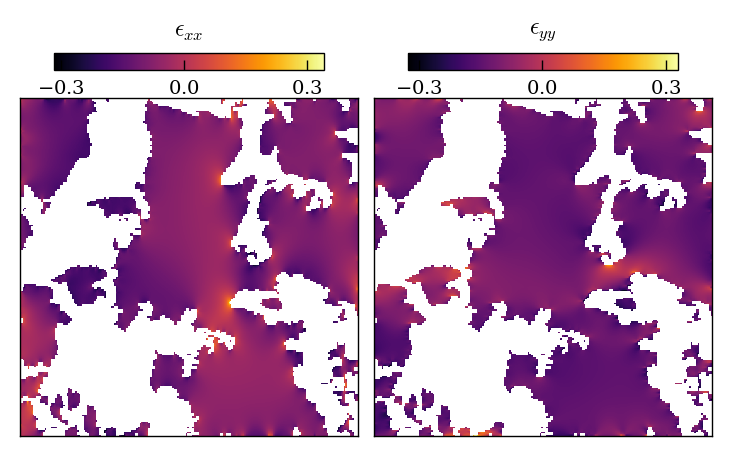

In [25]:
fig = plt.figure(figsize=set_size(fraction=0.5, height_ratio=1), dpi=200, constrained_layout=True)
gs1 = fig.add_gridspec(1, 2, wspace=0.001, hspace=0.001)

ax = fig.add_subplot(gs1[0, 0])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(eps[0, 0, :, :], mask=structure),
            title=r'$\epsilon_{xx}$')

ax = fig.add_subplot(gs1[0, 1])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(eps[1, 1, :, :], mask=structure),
            title=r'$\epsilon_{yy}$')


plt.show()

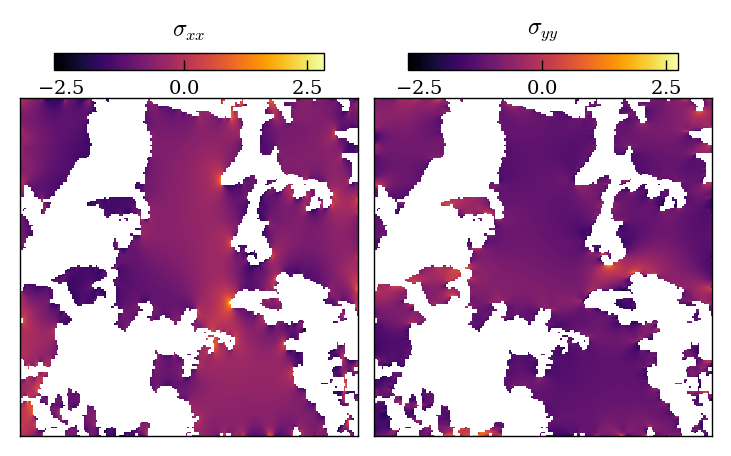

In [26]:
fig = plt.figure(figsize=set_size(fraction=0.5, height_ratio=1), dpi=200, constrained_layout=True)
gs1 = fig.add_gridspec(1, 2, wspace=0.001, hspace=0.001)

ax = fig.add_subplot(gs1[0, 0])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(sig[0, 0, :, :], mask=structure),
            title=r'$\sigma_{xx}$')

ax = fig.add_subplot(gs1[0, 1])
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(sig[1, 1, :, :], mask=structure),
            title=r'$\sigma_{yy}$')


plt.show()

## Anisotropic damage formulation

In [27]:
def compute_strain_energies(sig, eps, K, mu, structure):
    N = structure.shape[0]
  
    ddot22 = lambda A2,B2: np.einsum('ijxy  ,jixy  ->xy    ',A2,B2)
    trace2 = lambda A2   : np.einsum('iixy         ->xy    ',A2   )
    I2    = np.einsum('ij,xy'          ,                  np.eye(2)   ,np.ones([N,N]))

  
    strain_energy = 0.5*ddot22(sig, eps)
    strain_energy *= (1-structure) 

    # decomposition of strain and strain energy
    macluay_plus = lambda A : 0.5*(A+np.abs(A))
    macluay_minus = lambda A : 0.5*(A-np.abs(A))

    eps_dev = eps - trace2(eps)*I2/3             # deviatoric strain
    esp_plus = macluay_plus(trace2(eps))
    esp_minus = macluay_minus(trace2(eps))

    strain_energy_plus = 0.5*np.multiply(K, esp_plus**2) + np.multiply(mu, ddot22(eps_dev, eps_dev))
    strain_energy_minus = 0.5*np.multiply(K, esp_minus**2)

    # remove energies in the pore phase
    strain_energy_plus *= (1-structure)
    strain_energy_minus *= (1-structure)

    # condition to have 0 dmaage where positive strain energy < negative straina energy
    strain_energy_plus = np.where(strain_energy_plus < strain_energy_minus, 0, strain_energy_plus)

    return strain_energy, strain_energy_plus, strain_energy_minus

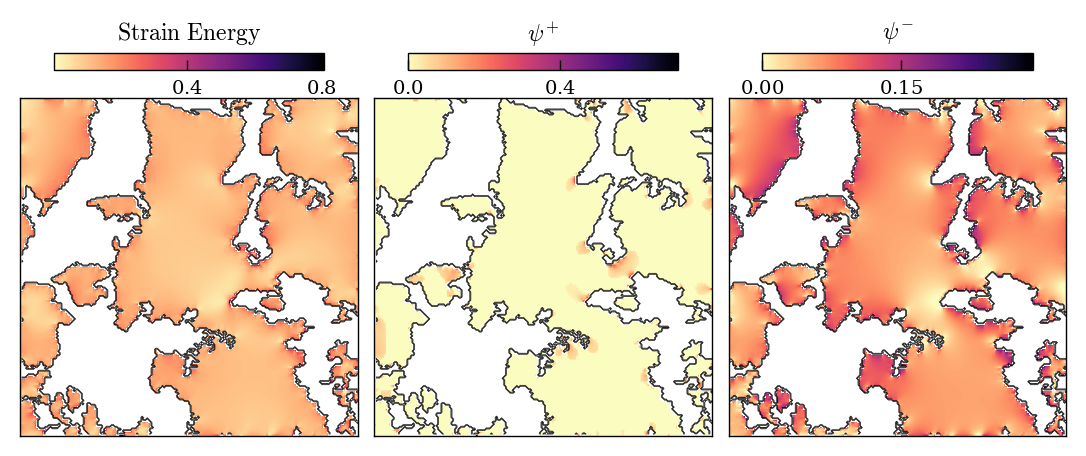

In [28]:
strain_energy, strain_energy_plus, strain_energy_minus = compute_strain_energies(sig=sig, 
                                                                                eps=eps,
                                                                                K=K0, mu=mu0, 
                                                                                structure=structure)

fig = plt.figure(figsize=set_size(fraction=0.75, height_ratio=1), dpi=200, constrained_layout=True)
gs1 = fig.add_gridspec(1, 3, wspace=0.001, hspace=0.001)

ax = fig.add_subplot(gs1[0, 0])
ax.contour(structure, 
                  origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(strain_energy, mask=structure ),
            title=r'$\mathrm{Strain~Energy}$', cmap='magma_r')

ax = fig.add_subplot(gs1[0, 1])
ax.contour(structure, 
                  origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(strain_energy_plus, mask=structure ),
            title=r'$\psi^{+}$', cmap='magma_r')


ax = fig.add_subplot(gs1[0, 2])
ax.contour(structure, 
                  origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(strain_energy_minus, mask=structure ),
            title=r'$\psi^{-}$', cmap='magma_r')


plt.show()

In [29]:
def compute_fracture(structure, history_field, Gc, initial_guess, l0=1e-2, k=1e-3, solver=sp.lgmres):
    N = structure.shape[0]
    ndim = len(structure.shape)
    shape  = [N,N]         # number of voxels in all directions
   
    dot = lambda A,B : np.einsum('ij,ji->ij', A, B)
    dot11  = lambda A1,B1: np.einsum('ixy   ,ixy   ->xy    ',A1,B1)
    
     # (inverse) Fourier transform (for each tensor component in each direction)
    fft  = lambda x: np.fft.fftshift(np.fft.fftn (np.fft.ifftshift(x),[N,N]))
    ifft = lambda x: np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x),[N,N]))

    
    x_2      = np.zeros([ndim   ,N,N],dtype='int64')  # position vectors
    q_2      = np.zeros([ndim   ,N,N],dtype='int64')  # frequency vectors
    Dq_2     = np.zeros([ndim   ,N,N],dtype='complex')  # frequency vectors

    # - set "x_2" as position vector of all grid-points
    x_2[0],x_2[1] = np.mgrid[:N,:N]

    # - convert positions "x_2" for frequencies "q_2"
    for i in range(ndim):
        freq   = np.arange(-(shape[i]-1)/2,+(shape[i]+1)/2,dtype='int64')
        q_2[i] = 2*np.pi*freq[x_2[i]]
        Dq_2[i] = 1j*q_2[i]
        
    # computing laplacian operator
    Q       = dot11(Dq_2,Dq_2)
    
    penalty = 0
    laplacian = lambda y : np.real(ifft( Q*fft(y) ))
    phasefield = lambda d : dot(history_field + 0.5*Gc/l0 + penalty, d) - 0.5*l0*dot(Gc, laplacian(d)) 
    GA_fun = lambda y : phasefield(y.reshape(shape)).reshape(-1)

    # initial residual
    bp = history_field - phasefield(initial_guess) 
    bp = bp.reshape(-1)
    
    nb_iterations = 0
    def callback(x):
        nonlocal nb_iterations
        nb_iterations += 1

    # solving phasefield equation 
    d, info =solver(
          A=sp.LinearOperator(shape=(N*N, N*N), matvec=GA_fun, dtype='float'),
            b=bp, 
            tol=1e-8, atol=1e-8, callback=callback
        )
    d = d.reshape(shape)
    d += initial_guess
    
    print('PhaseField Calculations converged :', nb_iterations)
    return d.T

In [30]:
l0 = 0.01 
gc = 1e-2 # 10 J/m2 
k = 1e-3

damage = compute_fracture(structure=structure, 
                          history_field=strain_energy_plus,
                          initial_guess=np.zeros_like(strain_energy_plus),
                          Gc=param(structure, gc, gc), l0=l0, k=k, 
                          solver=sp.lgmres)

PhaseField Calculations converged : 50


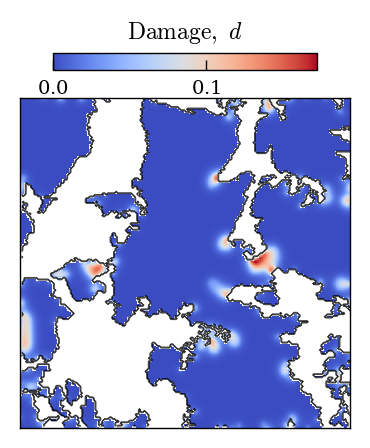

In [31]:
fig = plt.figure(figsize=set_size(fraction=0.3, height_ratio=1), dpi=200, constrained_layout=True)

ax = plt.axes()
ax.contour(structure, origin='lower', colors=['xkcd:black'], linewidths=0.1)
#ax.contour(np.ma.array(damage, mask=structure), levels=4,
#                  origin='lower', cmap='coolwarm', linewidths=0.5)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(damage, mask=structure ),
            title=r'$\mathrm{Damage},~d$', cmap='coolwarm')

plt.show()

In [32]:
def plot_imshow(fig, ax, quantity, title, cmap='inferno'):
    cs = ax.imshow(quantity, origin='lower', cmap=cmap)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    axins1 = ax.inset_axes([0.1, 1.085, 0.8, 0.05])

    cbar = fig.colorbar(cs, cax=axins1, pad=0.05, 
                      fraction=0.025, shrink=.5, orientation="horizontal")
    tick_locator = ticker.MaxNLocator(nbins=2)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.set_label(title, fontsize=8.5, labelpad=-28, y=0.85)
    cbar.ax.yaxis.set_offset_position('left')  

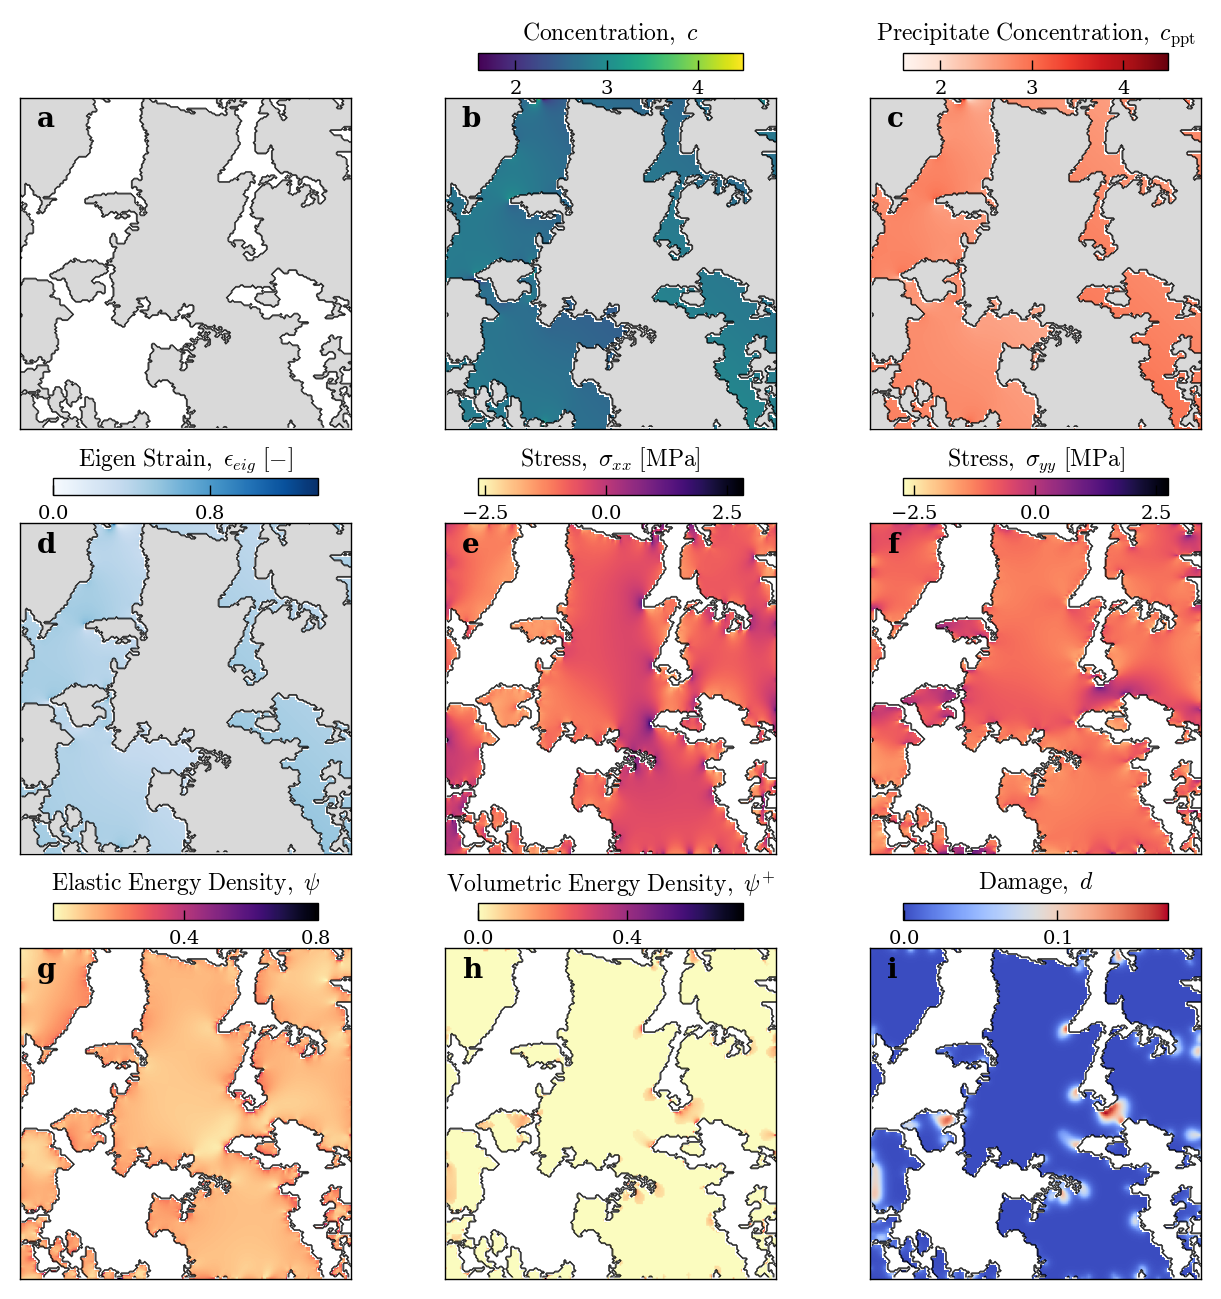

In [33]:
fig = plt.figure(figsize=set_size(fraction=0.9, height_ratio=1), constrained_layout=True, dpi=200)

gs1 = fig.add_gridspec(3, 3, wspace=0.001, hspace=0.0001)
ax = fig.add_subplot(gs1[0, 0])
ax.contourf(np.ma.array(1-structure[:, :], mask=structure), alpha=1,  cmap='Greys')
ax.contour(structure,
                  origin='lower', colors=['xkcd:black'], linewidths=0.1)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_aspect(1/ax.get_data_ratio())
put_label(ax, label='a')


ax = fig.add_subplot(gs1[0, 1])

ax.contourf(np.ma.array(1-structure[:, :], mask=structure), alpha=1,  cmap='Greys')
ax.contour(structure, origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(concentration, mask=1-structure)/2e-5,
            title=r'$\mathrm{Concentration,}~c$', cmap='viridis')
put_label(ax, label='b')


ax = fig.add_subplot(gs1[0, 2])
ax.contourf(np.ma.array(1-structure[:, :], mask=structure), alpha=1,  cmap='Greys')
ax.contour(structure, origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(precipitation, mask=1-structure)/2e-5,
            title=r'$\mathrm{Precipitate~Concentration,}~c_{\mathrm{ppt}}$', cmap='Reds')
put_label(ax, label='c')


ax = fig.add_subplot(gs1[1, 0])
ax.contourf(np.ma.array(1-structure[:, :], mask=structure), alpha=1,  cmap='Greys')
ax.contour(structure, origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(eigen_strain, mask=1-structure),
            title=r'$\mathrm{Eigen~Strain},~\epsilon_{eig}~[-]$', cmap='Blues')
put_label(ax, label='d')


ax = fig.add_subplot(gs1[1, 1])
ax.contour(1-structure, origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(sig[0, 0, :, :], mask=structure),
            title=r'$\mathrm{Stress},~\sigma_{xx}~[\mathrm{MPa}]$', cmap='magma_r')
put_label(ax, label='e')


ax = fig.add_subplot(gs1[1, 2])
ax.contour(1-structure, origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(sig[1, 1, :, :], mask=structure),
            title=r'$\mathrm{Stress},~\sigma_{yy}~[\mathrm{MPa}]$', cmap='magma_r')
put_label(ax, label='f')


ax = fig.add_subplot(gs1[2, 0])
ax.contour(structure, 
                  origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(strain_energy, mask=structure ),
            title=r'$\mathrm{Elastic~Energy~Density,~}\psi$', cmap='magma_r')
put_label(ax, label='g')


ax = fig.add_subplot(gs1[2, 1])
ax.contour(structure, 
                  origin='lower', colors=['xkcd:black'], linewidths=0.1)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(strain_energy_plus, mask=structure ),
            title=r'$\mathrm{Volumetric~Energy~Density,~}\psi^{+}$', cmap='magma_r')
put_label(ax, label='h')


ax = fig.add_subplot(gs1[2, 2])
ax.contour(structure, origin='lower', colors=['xkcd:black'], linewidths=0.1)
#ax.contour(np.ma.array(damage, mask=structure), levels=4,
#                  origin='lower', cmap='coolwarm', linewidths=0.5)
plot_imshow(fig=fig, ax=ax,
            quantity=np.ma.array(damage, mask=structure ),
            title=r'$\mathrm{Damage},~d$', cmap='coolwarm')
put_label(ax, label='i')
plt.show()